# Neural Networks

# Shallow Neural Network (Multi-Layer Perceptron)
A multilayer Perceptron is a variant of the original Perceptron model. It has one or more hidden layers between its input and output layers, the neurons are organized in layers, the connections are always directed from lower layers to upper layers, the neurons in the same layer are not interconnected.

<img src='./img/MLP.png' height=300 width=400></img>

**References**
- Ramchoun, Hassan & Amine, Mohammed & Janati Idrissi, Mohammed Amine & Ghanou, Youssef & Ettaouil, Mohamed. (2016). Multilayer Perceptron: Architecture Optimization and Training. International Journal of Interactive Multimedia and Artificial Inteligence. 4. 26-30. 10.9781/ijimai.2016.415. 

In [13]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utils import read_pickle, write_pickle
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import keras
from utils import read_pickle, write_pickle
import numpy as np
import pandas as pd

init_notebook_mode(connected=True)
np.random.seed(42)

## Import data sources
We import crafted features from previous preprocessing steps.

In [14]:
# import data
X = np.loadtxt('./data/feature_extraction.csv',delimiter=',')
y_ = pd.read_csv('./data/y_train.csv').values # remove headers
print('X shape:',X.shape,type(X))
print('y shape:',y_.shape,type(y_))

m = X.shape[0]

X shape: (3810, 81) <class 'numpy.ndarray'>
y shape: (3810, 3) <class 'numpy.ndarray'>


## Normalise features for better training outcomes

In [3]:
print('Before scaling:')
print(X[0:5,0:5])
zscore = StandardScaler()
X = zscore.fit_transform(X) #scales each feature column
print('After scaling:')
print(X[0:5,0:5])

Before scaling:
[[-2.48068359e-03 -3.30602998e-03  7.53164633e-03  2.63418294e-01
   2.98419490e+00]
 [ 4.60476531e-03 -7.75678062e-03  6.20627750e-03  1.21867458e-01
   2.76819294e+00]
 [ 2.64566328e-03 -9.23168299e-03  2.79891515e-02  1.49711430e-01
   2.88674457e+00]
 [ 6.23955469e-04 -2.80411156e-03  7.88664279e-03  2.01790516e-01
   2.65792233e+00]
 [ 6.96887805e-03  4.61085891e-02 -1.42385063e-01 -8.61712500e-02
   2.98149789e+00]]
After scaling:
[[-2.55876182e-01 -1.70952273e-01  1.22095825e-01  7.10781449e-01
   3.93302213e-01]
 [ 4.26164177e-01 -2.36298506e-01  1.16038537e-01 -3.92834696e-02
  -4.75995845e-01]
 [ 2.37582385e-01 -2.57953126e-01  2.15592055e-01  1.08259186e-01
   1.11418768e-03]
 [ 4.29742040e-02 -1.63583072e-01  1.23718253e-01  3.84221499e-01
  -9.19779004e-01]
 [ 6.53732016e-01  5.54556629e-01 -5.63063337e-01 -1.14166154e+00
   3.82448128e-01]]


## Encoding of y labels
While it is necessary to do one-hot encoding of labels, the tools we use here do not require OHE. StratifiedKFold directly uses the class number without requiring one-hot encoding. Similarly by using sparse_categorical_crossentropy as our model loss, we can directly use the class number. However we still need to convert class in string format into number format.

In [15]:
y = y_[:,-1] # last column is the y label

encoder = LabelEncoder()
y_multiclass = encoder.fit_transform(y)
print('y_multiclass shape:',y_multiclass.shape)
print('Encoded classes:',['{}:{}'.format(tup[0],tup[1]) for tup in enumerate(encoder.classes_)])

y_multiclass shape: (3810,)
Encoded classes: ['0:carpet', '1:concrete', '2:fine_concrete', '3:hard_tiles', '4:hard_tiles_large_space', '5:soft_pvc', '6:soft_tiles', '7:tiled', '8:wood']


## Determine each set of hyperparameters for K-fold evaluation
In our model, we shall attempt to find the best of hyperparameters. The tunable hyperparameters are:
- Number of Neurons in hidden layer 1
- Dropout value (post-activation at hidden layer 1)
- Epochs for training

In Keras we can also see the validation accuracy on every epoch.

In [9]:
hidden_neurons = [150,300,500]
dropouts = [0.1,0.25,0.5]
epochs = [30,60,100]

## Create Model
We create a MLP with 1 tunable hidden layer.

In [10]:
def create_model(hyperparams):
    # Create shallow NN model
    input_dim = X.shape[1]
    output_dim = len(encoder.classes_) # number of classes 
    hidden_dim_1 = hyperparams['hidden_layer']
    hidden_dim_2 = output_dim*5

    model = Sequential()
    model.add(Dense(hidden_dim_1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(hyperparams['dropout']))
    model.add(Dense(hidden_dim_2, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

#     model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Split Train-Test Set for later evaluation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multiclass, test_size=0.2)

## Train the model and evaluate each set of hyperparameters using K-Fold Cross Validation
As defined earlier, we will create various permutations of hyperparameters. Since there are 3 possible options for each adjustable hyperparameter, we will obtain a total of 27 possible cases.

In [12]:
kfold_splits = 5

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

val_loss_all = {}

# Enumerate over all possible combos
for i,neurons in enumerate(hidden_neurons):
    for j,dropout in enumerate(dropouts):
        for k,epoch in enumerate(epochs):
            print('Model hidden neurons = {}, dropout rate = {}, # epochs = {}'.format(neurons,dropout,epoch))
        
            val_loss_kfold = []

            # Loop through the indices the split() method returns
            for index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
                print("Training on fold " + str(index+1) + "/{}...".format(kfold_splits))

                # Generate batches from indices
                xtrain, xval = X[train_indices], X[val_indices]
                ytrain, yval = y_multiclass[train_indices], y_multiclass[val_indices]

                #define hyperparams set
                hyperparams = {}
                hyperparams['hidden_layer'] = neurons
                hyperparams['dropout'] = dropout
                hyperparams['epoch'] = epoch

                # Clear model, and create it
                model = None
                model = create_model(hyperparams)

                history = model.fit(xtrain, ytrain, epochs=hyperparams['epoch'], validation_data=(xval,yval),verbose=0)

                hist = history.history
                val_loss = hist['val_loss']
                loss = hist['loss']

                # for choosing best val acc
                val_loss_kfold.append(hist['val_loss'])
                print("Last training accuracy: " + str(hist['acc'][-1]) + ", last validation accuracy: " + str(hist['val_acc'][-1]))

            print('Average Loss: {}'.format(np.mean(val_loss_kfold)))
            val_loss_all[(neurons,dropout,epoch)] = np.mean(val_loss_kfold)
    
    

Model hidden neurons = 150, dropout rate = 0.1, # epochs = 30
Training on fold 1/5...
Last training accuracy: 0.7967980295566502, last validation accuracy: 0.6879084967320261
Training on fold 2/5...
Last training accuracy: 0.8034468608945424, last validation accuracy: 0.6792144027162106
Training on fold 3/5...
Last training accuracy: 0.7932731747822843, last validation accuracy: 0.7229508196721312
Training on fold 4/5...
Last training accuracy: 0.7893442622950819, last validation accuracy: 0.694078947368421
Training on fold 5/5...
Last training accuracy: 0.7836952069312615, last validation accuracy: 0.6820428325277577
Average Loss: 1.1126858926683298
Model hidden neurons = 150, dropout rate = 0.1, # epochs = 60
Training on fold 1/5...
Last training accuracy: 0.8908045977011494, last validation accuracy: 0.738562091503268
Training on fold 2/5...
Last training accuracy: 0.8801805498563808, last validation accuracy: 0.736497545105736
Training on fold 3/5...
Last training accuracy: 0.88515

Last training accuracy: 0.8051681705827689, last validation accuracy: 0.7131147540983607
Training on fold 4/5...
Last training accuracy: 0.8045081967213115, last validation accuracy: 0.6973684210526315
Training on fold 5/5...
Last training accuracy: 0.817287996795909, last validation accuracy: 0.6886326182615227
Average Loss: 1.069410482920408
Model hidden neurons = 300, dropout rate = 0.25, # epochs = 60
Training on fold 1/5...
Last training accuracy: 0.8842364532019704, last validation accuracy: 0.7222222222222222
Training on fold 2/5...
Last training accuracy: 0.888797702092737, last validation accuracy: 0.7201309329456667
Training on fold 3/5...
Last training accuracy: 0.8872026251025431, last validation accuracy: 0.7180327868852459
Training on fold 4/5...
Last training accuracy: 0.8774590163934426, last validation accuracy: 0.7220394736842105
Training on fold 5/5...
Last training accuracy: 0.8861122491026647, last validation accuracy: 0.7265238867952953
Average Loss: 1.04257172983

Last training accuracy: 0.8427750410509032, last validation accuracy: 0.7075163398692811
Training on fold 2/5...
Last training accuracy: 0.8370947887235163, last validation accuracy: 0.7135842880523732
Training on fold 3/5...
Last training accuracy: 0.837161607924204, last validation accuracy: 0.7245901639344262
Training on fold 4/5...
Last training accuracy: 0.8430327868852459, last validation accuracy: 0.7549342105263158
Training on fold 5/5...
Last training accuracy: 0.8488324457678039, last validation accuracy: 0.7281713332532854
Average Loss: 1.010669154741661
Model hidden neurons = 500, dropout rate = 0.5, # epochs = 100
Training on fold 1/5...
Last training accuracy: 0.9006568144499179, last validation accuracy: 0.7271241830065359
Training on fold 2/5...
Last training accuracy: 0.8916700862204388, last validation accuracy: 0.7430441899502531
Training on fold 3/5...
Last training accuracy: 0.8892534864154187, last validation accuracy: 0.6852459016393443
Training on fold 4/5...
La

In [14]:
# convert dict of validation losses to 3d coordinate format + value
heatmap_3d = np.zeros([0,4])
for key,value in val_loss_all.items():
    heatmap_3d = np.vstack((heatmap_3d,[hidden_neurons.index(key[0]),dropouts.index(key[1]),epochs.index(key[2]),value]))

## Visualise the best hyperparameter selection
In the diagram, we want to visualise the losses in a 3d space, allowing us to quickly draw trends or get the lowest/highest losses. Drag & hold to visualise the 3d heatmap from different angles.

In [15]:
# Using plotly's Scatter3d

trace1 = go.Scatter3d(
    x=heatmap_3d[:,0],
    y=heatmap_3d[:,1],
    z=heatmap_3d[:,2],
    mode='markers',
    marker=dict(
        size=24,
        color=heatmap_3d[:,3],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(
    title='Validation Loss',
    width=800,
    height=800,
    scene = dict(
    xaxis=dict(
        ticktext=hidden_neurons,
        tickvals=[0,1,2],
        nticks=3,
        title='# Hidden Neurons'
    ),
    yaxis=dict(
        ticktext=dropouts,
        tickvals=[0,1,2],
        nticks=3,
        title='Dropout Rate'
    ),
    zaxis=dict(
        ticktext=epochs,
        tickvals=[0,1,2],
        nticks=3,
        title='# Epochs'
    )
))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

From the above plot, we compare between any of the 2 hyperparameter dimensions. All validation losses are referred to as K-fold validation losses. Let us explain some of the observations:

**1) dropout vs hidden neurons (@ epochs = 30)**

We observe that with increased learning capacity (hidden neurons = 500), increasing dropout rate actually reduces the validation loss. However, with lower learning capacity (hidden neurons = 150,300), increasing dropout actually harms the performance of the model by increasing the validation loss. This is expected, because with increasingly complex models, it is more likely to overfit, hence dropouts serve as regularisation parameters, which improves the model's ability to generalise. We also observe that for higher dropout rates (0.25,0.5), performance improves with increasing hidden neurons. If we try to apply more regularisation to models with lower learning capacity, we will observe higher bias and poorer performance.

**2) Epochs vs hidden neurons (@ dropout = 0.1)**

We observe that with more hidden neurons, performance is better with less training epochs. The lowest validation loss is at 100 epochs for a model with 150 hidden neurons, whereas the lowest validation loss is at 30 epochs for a model with 300 & 500 hidden neurons. With more neurons, we increase the complexity & expressiveness of the model, hence resulting in faster convergence. Any further training resulted in worsening performance (increased validation losses). Furthermore, due to the low dropout rate for this case, it is easy for the model to overfit.

**3) Epochs vs dropout (@ hidden neurons = 500)**

We see that for low dropout rates, we quickly converge and any further training hurts the performance. At increasing dropout rates, performance improved with more epochs, as more iterations are required for the model to converge. For a more complex model, regardless at any epoch counts, we observe that performance improves with increased dropout.

In [16]:
# Get best hyperparameter set based on val loss
val_loss_best,best_hyper = min(val_loss_all.values()),min(val_loss_all,key=val_loss_all.get)
print('The best combinaton belongs to {}, with a lowest val loss of {}.'.format(best_hyper,val_loss_best))

The best combinaton belongs to (300, 0.5, 100), with a lowest val loss of 0.9736789880662522.


## Retrain the best model
From the previous step, we have determined that the best model has the hyperparameters:
- Hidden Layer Neurons = 300
- Dropout = 0.5
- Epochs = 100

Now we will retrain this permutation using all available training data and visualise the process.

Train on 2438 samples, validate on 610 samples
Epoch 1/100
2438/2438 [==============================] - 6s 2ms/step - loss: 1.8150 - acc: 0.3687 - val_loss: 1.5965 - val_acc: 0.4852
Epoch 2/100
2438/2438 [==============================] - 1s 288us/step - loss: 1.5398 - acc: 0.4742 - val_loss: 1.4274 - val_acc: 0.5066
Epoch 3/100
2438/2438 [==============================] - 1s 255us/step - loss: 1.4219 - acc: 0.5012 - val_loss: 1.3582 - val_acc: 0.5279
Epoch 4/100
2438/2438 [==============================] - 1s 250us/step - loss: 1.3350 - acc: 0.5422 - val_loss: 1.2937 - val_acc: 0.5656
Epoch 5/100
2438/2438 [==============================] - 1s 240us/step - loss: 1.2725 - acc: 0.5595 - val_loss: 1.2539 - val_acc: 0.5672
Epoch 6/100
2438/2438 [==============================] - 1s 239us/step - loss: 1.2161 - acc: 0.5681 - val_loss: 1.2344 - val_acc: 0.5803
Epoch 7/100
2438/2438 [==============================] - 1s 238us/step - loss: 1.1789 - acc: 0.5796 - val_loss: 1.2132 - val_acc: 0.5

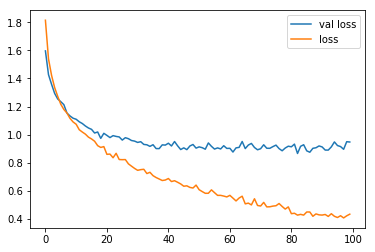

In [17]:
#define hyperparams set
best_hyperparams = {}
best_hyperparams['hidden_layer'] = best_hyper[0]
best_hyperparams['dropout'] = best_hyper[1]
best_hyperparams['epoch'] = best_hyper[2]

model = create_model(best_hyperparams)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=best_hyperparams['epoch'],verbose=1)
    
# plot loss history
hist = history.history
val_loss = hist['val_loss']
loss = hist['loss']
plt.figure()
plt.plot(val_loss)
plt.plot(loss)
plt.legend(['val loss','loss'])

In [18]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

762/762 [==============================] - 0s 137us/step

acc: 74.80%


## Analysis of Results
From the above loss plot, we see that training loss is decreasing. However, validation loss appears to plateau at about 50 epochs. Despite training for more epochs, the model does not show signs of overfitting yet. **Both the validation and test accuracy showed good accuracies of 75%**.

## Kaggle submission

In [19]:
X_test = np.loadtxt('./data/feature_extraction_kaggle.csv',delimiter=',')
m_test = X_test.shape[0]
zscore_test = StandardScaler()
X_test = zscore.fit_transform(X_test) #scales each feature column
predictions = np.argmax(model.predict(X_test),axis=1)
idx = np.arange(m_test)
predictions_str = encoder.inverse_transform(predictions)

df_test = {'series_id':idx,
           'surface':predictions_str
          }
df_test = pd.DataFrame(df_test)
df_test.to_csv('./kaggle/kaggle.csv',index=False)

# Long Short-Term-Memory
Long short-term memory (LSTM) is an artificial recurrent neural network, (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections to itself. It differs from the Vanilla RNN by incorporating input, forget and output gates.

<img src='./img/LSTM.png' height=300 width=500></img>

**References**
- Hochreiter, Sepp & Schmidhuber, Jürgen. (1997). Long Short-term Memory. Neural computation. 9. 1735-80. 10.1162/neco.1997.9.8.1735. 

In [17]:
# import time-series data
X = read_pickle('./data/time-series.pickle')
print('X shape:',X.shape)

X shape: (3810, 128, 9)


As we want to preserve the scale and absolute value of our quantities, we do not normalise or rescale them. This preserves physical interpretation of the feature.

## Create Model
We create a model with 1 or 2 LSTM layers.

In [84]:
def create_model(hyperparams):
    # Create LSTM Model
    timesteps = X.shape[1]
    data_dim = X.shape[2]
    output_dim = len(encoder.classes_) # number of classes 
    hidden_dim_1 = 64
    hidden_dim_2 = 32
    
    model = Sequential()
    # if extra layer, we add dropout after 1st layer
    if(hyperparams['extra_layer']==True):
        model.add(LSTM(hidden_dim_1, return_sequences=True,
               input_shape=(timesteps, data_dim)))
        model.add(Dropout(hyperparams['dropout']))
        model.add(LSTM(hidden_dim_2, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))
    # if no extra layer, we add dropout after LSTM layer
    else:
        model.add(LSTM(hidden_dim_1,
               input_shape=(timesteps, data_dim)))
        model.add(Dropout(hyperparams['dropout']))
        model.add(Dense(output_dim, activation='softmax'))        

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Determine each set of hyperparameters for K-fold evaluation
In our model, we shall attempt to find the best of hyperparameters. The tunable hyperparameters are:
- Dropout value (only after 1st LSTM layer)
- No. of LSTM layers (1 or 2)

In Keras we can also see the validation accuracy on every epoch.

In [80]:
dropouts = [0.1,0.25,0.5]
extra_layer = [True,False]

## Split Train-Test Set for later evaluation

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multiclass, test_size=0.2)

## Train the model and evaluate each set of hyperparameters using K-Fold Cross Validation
As defined earlier, we will create various permutations of hyperparameters. Since there are 2 and 3 possible options for each adjustable hyperparameter, we will obtain a total of 6 possible cases.

In [85]:
kfold_splits = 3

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

# val_loss_all = {}

# Enumerate over all possible combos
for i,add_LSTM in enumerate(extra_layer):
    for j,dropout in enumerate(dropouts):
        print('Model extra LSTM layer = {}, dropout rate = {}'.format(add_LSTM,dropout))

        val_loss_kfold = []

        # Loop through the indices the split() method returns
        for index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
            print("Training on fold " + str(index+1) + "/{}...".format(kfold_splits))

            # Generate batches from indices
            xtrain, xval = X[train_indices], X[val_indices]
            ytrain, yval = y_multiclass[train_indices], y_multiclass[val_indices]

            #define hyperparams set
            hyperparams = {}
            hyperparams['extra_layer'] = add_LSTM
            hyperparams['dropout'] = dropout

            # Clear model, and create it
            model = None
            model = create_model(hyperparams)

            history = model.fit(xtrain, ytrain, epochs=30, validation_data=(xval,yval),verbose=1, batch_size=128)

            hist = history.history
            val_loss = hist['val_loss']
            loss = hist['loss']

            # for choosing best val acc
            val_loss_kfold.append(hist['val_loss'])
            print("Last training accuracy: " + str(hist['acc'][-1]) + ", last validation accuracy: " + str(hist['val_acc'][-1]))

        print('Average Loss: {}'.format(np.mean(val_loss_kfold)))
        val_loss_all[(add_LSTM,dropout)] = np.mean(val_loss_kfold)



Model extra LSTM layer = False, dropout rate = 0.1
Training on fold 1/3...
Train on 2028 samples, validate on 1020 samples
Epoch 1/30
2028/2028 [==============================] - 6s 3ms/step - loss: 2.1290 - acc: 0.1706 - val_loss: 2.0003 - val_acc: 0.2725
Epoch 2/30
2028/2028 [==============================] - 3s 1ms/step - loss: 2.0145 - acc: 0.2337 - val_loss: 1.9638 - val_acc: 0.2637
Epoch 3/30
2028/2028 [==============================] - 2s 1ms/step - loss: 1.9674 - acc: 0.2559 - val_loss: 1.9463 - val_acc: 0.3000
Epoch 4/30
2028/2028 [==============================] - 2s 1ms/step - loss: 1.9149 - acc: 0.2944 - val_loss: 1.8832 - val_acc: 0.3412
Epoch 5/30
2028/2028 [==============================] - 2s 1ms/step - loss: 1.8846 - acc: 0.3062 - val_loss: 1.8398 - val_acc: 0.3539
Epoch 6/30
2028/2028 [==============================] - 2s 1ms/step - loss: 1.8054 - acc: 0.3486 - val_loss: 1.7721 - val_acc: 0.3627
Epoch 7/30
2028/2028 [==============================] - 2s 1ms/step - los

Epoch 30/30
2033/2033 [==============================] - 3s 2ms/step - loss: 1.2545 - acc: 0.5524 - val_loss: 1.3176 - val_acc: 0.5182
Last training accuracy: 0.5523856362567063, last validation accuracy: 0.5182266013669263
Training on fold 3/3...
Train on 2035 samples, validate on 1013 samples
Epoch 1/30
2035/2035 [==============================] - 7s 3ms/step - loss: 2.1074 - acc: 0.1867 - val_loss: 2.0101 - val_acc: 0.2310
Epoch 2/30
2035/2035 [==============================] - 3s 2ms/step - loss: 1.9933 - acc: 0.2570 - val_loss: 1.9667 - val_acc: 0.2498
Epoch 3/30
2035/2035 [==============================] - 3s 2ms/step - loss: 1.9533 - acc: 0.2722 - val_loss: 1.9134 - val_acc: 0.2902
Epoch 4/30
2035/2035 [==============================] - 3s 2ms/step - loss: 1.8759 - acc: 0.3297 - val_loss: 1.8075 - val_acc: 0.3603
Epoch 5/30
2035/2035 [==============================] - 4s 2ms/step - loss: 1.7764 - acc: 0.3656 - val_loss: 1.7472 - val_acc: 0.3870
Epoch 6/30
2035/2035 [============

Epoch 28/30
2028/2028 [==============================] - 3s 2ms/step - loss: 1.3083 - acc: 0.5483 - val_loss: 1.3551 - val_acc: 0.5127
Epoch 29/30
2028/2028 [==============================] - 3s 2ms/step - loss: 1.3189 - acc: 0.5350 - val_loss: 1.3234 - val_acc: 0.5186
Epoch 30/30
2028/2028 [==============================] - 3s 2ms/step - loss: 1.3046 - acc: 0.5562 - val_loss: 1.3398 - val_acc: 0.5039
Last training accuracy: 0.5562130165758453, last validation accuracy: 0.5039215693286822
Training on fold 2/3...
Train on 2033 samples, validate on 1015 samples
Epoch 1/30
2033/2033 [==============================] - 7s 3ms/step - loss: 2.1396 - acc: 0.1820 - val_loss: 2.0385 - val_acc: 0.2266
Epoch 2/30
2033/2033 [==============================] - 4s 2ms/step - loss: 2.0132 - acc: 0.2159 - val_loss: 1.9906 - val_acc: 0.2414
Epoch 3/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.9771 - acc: 0.2445 - val_loss: 1.9541 - val_acc: 0.2729
Epoch 4/30
2033/2033 [==========

2035/2035 [==============================] - 4s 2ms/step - loss: 1.3755 - acc: 0.5042 - val_loss: 1.3927 - val_acc: 0.5104
Epoch 27/30
2035/2035 [==============================] - 4s 2ms/step - loss: 1.3745 - acc: 0.4963 - val_loss: 1.4660 - val_acc: 0.4926
Epoch 28/30
2035/2035 [==============================] - 4s 2ms/step - loss: 1.4065 - acc: 0.4806 - val_loss: 1.4014 - val_acc: 0.5104
Epoch 29/30
2035/2035 [==============================] - 4s 2ms/step - loss: 1.3770 - acc: 0.5012 - val_loss: 1.3634 - val_acc: 0.5192
Epoch 30/30
2035/2035 [==============================] - 4s 2ms/step - loss: 1.3193 - acc: 0.5111 - val_loss: 1.3689 - val_acc: 0.5153
Last training accuracy: 0.5110565124331294, last validation accuracy: 0.5153010861482931
Average Loss: 1.59650436552664
Model extra LSTM layer = False, dropout rate = 0.5
Training on fold 1/3...
Train on 2028 samples, validate on 1020 samples
Epoch 1/30
2028/2028 [==============================] - 8s 4ms/step - loss: 2.2053 - acc: 0.16

Epoch 24/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.5038 - acc: 0.4771 - val_loss: 1.5289 - val_acc: 0.4571
Epoch 25/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.4943 - acc: 0.4747 - val_loss: 1.4644 - val_acc: 0.4985
Epoch 26/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.4742 - acc: 0.4894 - val_loss: 1.5052 - val_acc: 0.4650
Epoch 27/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.5663 - acc: 0.4525 - val_loss: 1.4877 - val_acc: 0.4936
Epoch 28/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.5025 - acc: 0.4752 - val_loss: 1.4547 - val_acc: 0.5044
Epoch 29/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.4520 - acc: 0.5012 - val_loss: 1.4182 - val_acc: 0.5064
Epoch 30/30
2033/2033 [==============================] - 4s 2ms/step - loss: 1.4534 - acc: 0.5052 - val_loss: 1.4847 - val_acc: 0.4768
Last training accuracy: 0.5051647808038127, last valida

In [86]:
# Get best hyperparameter set based on val loss
val_loss_best,best_hyper = min(val_loss_all.values()),min(val_loss_all,key=val_loss_all.get)
print('The best combinaton belongs to {}, with a lowest val loss of {}.'.format(best_hyper,val_loss_best))

The best combinaton belongs to (False, 0.1), with a lowest val loss of 1.5802771663348367.


## Retrain the best model
From the previous step, we have determined that the best model has the hyperparameters:
- Extra LSTM Layer: False
- Dropout = 0.1

Now we will retrain this permutation using all available training data and visualise the process.

Train on 2438 samples, validate on 610 samples
Epoch 1/30
2438/2438 [==============================] - 8s 3ms/step - loss: 2.0032 - acc: 0.2309 - val_loss: 1.9368 - val_acc: 0.3082
Epoch 2/30
2438/2438 [==============================] - 4s 2ms/step - loss: 1.8320 - acc: 0.3322 - val_loss: 1.7903 - val_acc: 0.3508
Epoch 3/30
2438/2438 [==============================] - 4s 1ms/step - loss: 1.7443 - acc: 0.3671 - val_loss: 1.7117 - val_acc: 0.3869
Epoch 4/30
2438/2438 [==============================] - 4s 2ms/step - loss: 1.6717 - acc: 0.3893 - val_loss: 1.6345 - val_acc: 0.4033
Epoch 5/30
2438/2438 [==============================] - 4s 2ms/step - loss: 1.6056 - acc: 0.4180 - val_loss: 1.6624 - val_acc: 0.4016
Epoch 6/30
2438/2438 [==============================] - 5s 2ms/step - loss: 1.5865 - acc: 0.4184 - val_loss: 1.5857 - val_acc: 0.4246
Epoch 7/30
2438/2438 [==============================] - 5s 2ms/step - loss: 1.5465 - acc: 0.4450 - val_loss: 1.5631 - val_acc: 0.4361
Epoch 8/30
2438

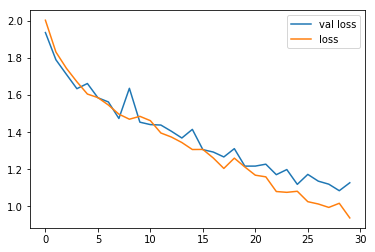

In [88]:
#define hyperparams set
best_hyperparams = {}
best_hyperparams['extra_layer'] = best_hyper[0]
best_hyperparams['dropout'] = best_hyper[1]

model = create_model(best_hyperparams)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30,verbose=1)
    
# plot loss history
hist = history.history
val_loss = hist['val_loss']
loss = hist['loss']
plt.figure()
plt.plot(val_loss)
plt.plot(loss)
plt.legend(['val loss','loss'])

In [89]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

762/762 [==============================] - 0s 323us/step

acc: 59.97%


## Analysis and discussion of LSTM model
Compared to MLP, LSTM's training and validation loss fluctuates very heavily. This can be attributed to the dropout and also training by mini-batch gradient descent. Since we don't pass all the data at one go, it is expected that the model descends in a slightly random manner, since every mini batch gives different data. 2 stacked LSTM layers performed worse than a single layer. For the best LSTM model, there is still room for further training to decrase the training and validation loss.